'Project code for tools'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('CompleteDataset_modified.csv')

/Users/yahanhu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Best_Squard formation

In [84]:
formation_choice = {'433':('GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CDM', 'RM', 'LW', 'ST', 'RW'),'424':('GK', 'LB', 'CB', 'CB', 'RB','LM','RM','CF','LW','ST','RW')}

def formation_choose():
    n = input("Choose the formation you want to know")
    if n in formation_choice.keys():
        choice = list(formation_choice[n])
        return choice
    else:
        print("Sorry, this formation doesn't exist")

choice=formation_choose()  
def formation_matrix(choice):
    for i in choice:
        formation_score = []
        for j in df.index:
            if i in df.loc[j,'Preferred Positions']:
                formation_score.append((df.loc[j,'Preferred Positions'],df.loc[j,'Name'],df.loc[j,'Overall']))
        first = sorted(formation_score, key=lambda x:x[2],reverse = True)[0]
        print(first)

formation_score = formation_matrix(choice) 

Choose the formation you want to know433
('GK ', 'M. Neuer', 92)
('LB ', 'Marcelo', 87)
('CB ', 'Sergio Ramos', 90)
('CB ', 'Sergio Ramos', 90)
('LB RB CB ', 'Azpilicueta', 85)
('RM LW ST LM ', 'A. Sánchez', 89)
('CDM CM ', 'T. Kroos', 90)
('RM CM CAM ', 'K. De Bruyne', 89)
('ST LW ', 'Cristiano Ronaldo', 94)
('ST LW ', 'Cristiano Ronaldo', 94)
('RW ', 'L. Messi', 93)


### comparing player

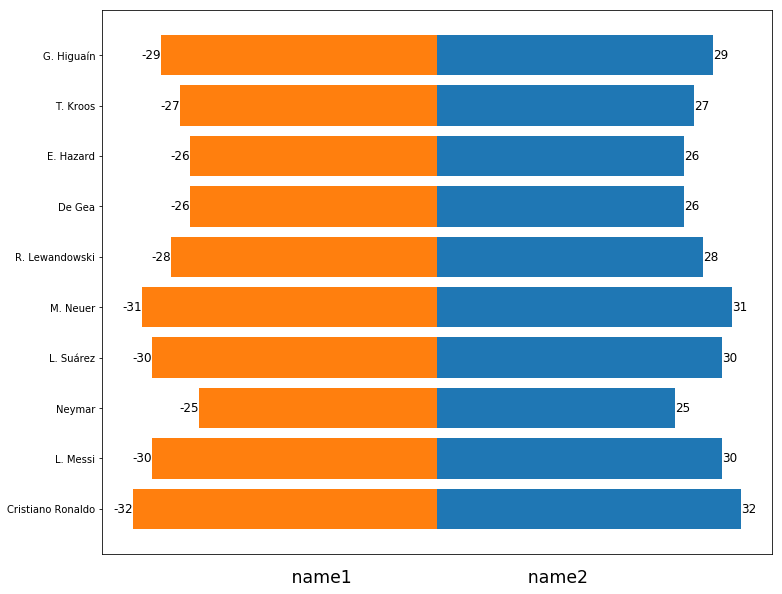

In [3]:
def player_compare(names,df):
    import matplotlib.pyplot as plt
    #Overall,Potential,Value,Age
    #Acceleration,Dribbling,Long passing,Short passing,Shot power,Strength,Marking)
    name1 = names[0]
    name2 = names[1]
    df[['Age']] = df[['Age']].astype(int)
    df[['Overall']] = df[['Overall']].astype(int)
    df[['Potential']] = df[['Potential']].astype(int)
    df[['Value']] = df[['Value']].astype(str)

    df1 = df[(df['Name'] == name1)]
    df1 = df1[['Potential','Overall','Value','Age']]
    df1.columns = [['Potential (100)','Overall (100)','Value (€)','Age']]
    df1 = df1.T
    df1.reset_index(level=0, inplace=True)
    df1.columns = ['property','data']
    x = df1['property']
    y1 = df1['data']

    df2 = df[(df['Name'] == name2)]
    df2 = df2[['Potential','Overall','Value','Age']]
    df2.columns = [['Potential (100)','Overall (100)','Value (€)','Age']]
    df2 = df2.T
    df2.reset_index(level=0, inplace=True)
    df2.columns = ['property','data']
    y2 = df2['data'].apply(lambda x : -x)

    fig = plt.figure(figsize=(12,4))
    plt.barh(x, y1)
    plt.barh(x, y2)

    plt.xticks(())
    plt.xlabel('%s                         %s'%(name1,name2),labelpad = 15, fontsize = 'xx-large')
    for x, y, z in zip(x, y1, y2):
    #ha: horizontal alignmen
    #va: vertical alignment
        plt.text(y, x, '%d' % y, ha='left', va = 'center', fontsize = 'large')  
        plt.text(z, x, '%d' % -z , ha='right',va = 'center', fontsize = 'large')

### Age and Score Analysis

Text(0.5,1,'Relationship between Age and Score')

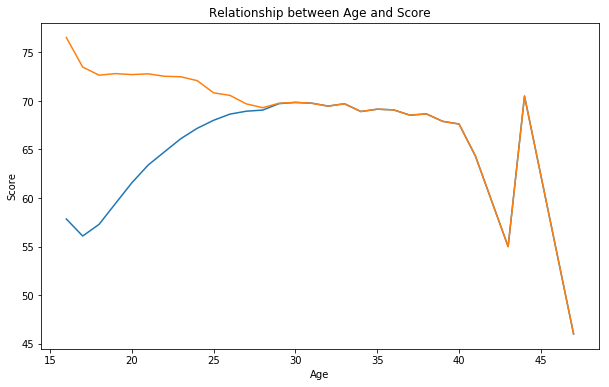

In [4]:
df = df[['Age', 'Overall', 'Potential']]
# Save all non-repeating ages in the database as a list
Age = list(set(df['Age']))

# Calculate the mean of overall scores of players at each age
gr_Overall = df['Overall'].groupby(df['Age'])
Overall_mean = gr_Overall.mean()
gr_Potential = df['Potential'].groupby(df['Age'])
Potential_mean = gr_Potential.mean()

# Plot the relationship of age and scores
plt.figure(figsize=(10,6))
plt.plot(Age,Overall_mean,label='Overall')
plt.plot(Age,Potential_mean,label='Potential')
plt.xlabel('Age')
plt.ylabel('Score')
plt.title('Relationship between Age and Score')

In [3]:
df.dropna(inplace = True)

In [4]:
l = ['Age',
 'Special',
 'Acceleration',
 'Aggression',
 'Agility',
 'Balance',
 'Ball control',
 'Composure',
 'Crossing',
 'Curve',
 'Dribbling',
 'Finishing',
 'Free kick accuracy',
 'GK diving',
 'GK handling',
 'GK kicking',
 'GK positioning',
 'GK reflexes',
 'Heading accuracy',
 'Interceptions',
 'Jumping',
 'Long passing',
 'Long shots',
 'Marking',
 'Penalties',
 'Positioning',
 'Reactions',
 'Short passing',
 'Shot power',
 'Sliding tackle',
 'Sprint speed',
 'Stamina',
 'Standing tackle',
 'Strength',
 'Vision',
 'Volleys',
 'CAM',
 'CB',
 'CDM',
 'CF',
 'CM',
 'LAM',
 'LB',
 'LCB',
 'LCM',
 'LDM',
 'LF',
 'LM',
 'LS',
 'LW',
 'LWB',
 'RAM',
 'RB',
 'RCB',
 'RCM',
 'RDM',
 'RF',
 'RM',
 'RS',
 'RW',
 'RWB',
 'ST']

In [ ]:
import re
for i in l:
    for j in df.index:
        x = df.loc[j,i]
        if type(x) == str:
            pattern1 = r'^(?P<num1>\d+)+(?P<num2>\d+)'
            flags = (
                re.IGNORECASE |  # Match against upper and lower case with one case
                re.VERBOSE  # Match with comments
                )
            match1 = re.match(pattern1, x, flags=flags)
            pattern2 = r'^(?P<num1>\d+)-(?P<num2>\d+)'
            match2 = re.match(pattern2, x, flags=flags)
            if match1:
                num1 = match1.group('num1') 
                num2 = match1.group('num2') 
                df.loc[j,i] = int(num1)+int(num2)
            if match2:
                num1 = match1.group('num1') 
                num2 = match1.group('num2') 
                df.loc[j,i] = int(num1)-int(num2)

In [ ]:
df.to_csv('CompleteDataset_modify.csv', encoding='utf-8')
d = pd.read_csv('CompleteDataset_modify.csv')

In [ ]:
import re
# Clean data of column 'Value'
for j in df.index:
    x = df.loc[j,'Value']
    if type(x) == str:
        pattern1 = r'^(?P<currency>\D+)(?P<value>\d*\.?\d+)(?P<unit>M)'
        flags = (
            re.IGNORECASE |  # Match against upper and lower case with one case
            re.VERBOSE  # Match with comments
            )
        match1 = re.match(pattern1, x, flags=flags)
        pattern2 = r'^(?P<currency>\D+)(?P<value>\d*\.?\d+)(?P<unit>K)'
        match2 = re.match(pattern2, x, flags=flags)
        pattern3 = r'^(?P<currency>\D+)(?P<value>\d+)$'
        match3 = re.match(pattern3, x, flags=flags)
        if match1:
            value1 = match1.group('value')
            df.loc[j,'Value'] = float(value1) * 1000000
        if match2:
            value2 = match2.group('value')
            df.loc[j,'Value'] = float(value2) * 1000
        if match3:
            value3 = match3.group('value')
            df.loc[j,'Value'] = int(value3)

In [ ]:
df.to_csv('CompleteDataset_modified.csv', encoding='utf-8')
d = pd.read_csv('CompleteDataset_modified.csv')